### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.signal import lfilter

from kalman_filter import KalmanFilter
from extended_kalman_filter import ExtendedKalmanFilter

### Statistik

In [4]:
z = np.array([0.63, -0.11, 0.03, 0.11, -0.41, -0.2, 0.0, 0.23, -0.75, -0.01])

print(f'mean           = {np.mean(z)}')           # mittelwert
print(f'quadratic mean = {np.mean(z**2)}')        # quadratischer mittelwert
print(f'median         = {np.median(z)}')
print(f'variance       = {np.var(z, ddof=0)}')    # varianz
print(f'std            = {np.std(z, ddof=0)}')    # standardabweichung

mean           = -0.048
quadratic mean = 0.12456
median         = -0.005
variance       = 0.122256
std            = 0.34965125482400317


### Pseudo-Noise

In [ ]:
Nrep = 30  # Anzahl Wiederholungen
W = 24  # Wortbreite
M = 12  # Memory des LFSR
L = (2**12) -1 # Länge MLS- bzw. PN-Sequenz.

# Initialize the sequence
s = np.zeros(L)
s[:M] = 1  # Seed or initial value of the shift register
 
# Generate the PN sequence
for m in range(M, L):
    s[m] = (s[m-6] +s[m-8] + s[m-11] + s[m-12]) %2  # p(X) = 1+X6+X8+X11+X12
 
# Convert binary to bipolar: 0 => 1 and 1 => -1
s = 1 - 2 * s
 
# Generate N repetition of PN-sequence
x = np.tile(s, Nrep)

### Korrelation

In [ ]:
def correlate(x, y): 
    """
    correlates x with y
    
    ! moves y !
    """
    rxy = np.correlate(y, x, 'full')
    lags = np.arange(-len(y)+1, len(x), dtype=int)[::-1]

    return np.column_stack((lags, rxy))

In [15]:
y = np.array([1,1,1,-1,-1,1,-1], dtype=float)
x = np.array([0.4, 0.5, -0.5, 0.4, 1.3, -0.3, 0.2, -1.0, 0.7, -0.8, -0.6, 0.5])

rxx = correlate(x,x)
rxy = correlate(x,y) # cross-corrolate y with x

print(rxy)

[[-6.   0.5]
 [-5.  -0.1]
 [-4.  -0.9]
 [-3.  -1.2]
 [-2.  -1. ]
 [-1.   1.8]
 [ 0.  -2.1]
 [ 1.   1.3]
 [ 2.   3.7]
 [ 3.  -0.4]
 [ 4.   0.6]
 [ 5.  -1.8]
 [ 6.   2.6]
 [ 7.  -0.5]
 [ 8.  -1.8]
 [ 9.   0.6]
 [10.  -0.1]
 [11.  -0.4]]


### LMS

In [ ]:
N_FIR = 1   # filter ordnung
N_Iter = 2  # lms iterationen
mu_max = 1 / (N_FIR + 1) # maximale learnrate

enable_print = True

# learnrate
mu = 0.1*mu_max
mu = 0.25

# init vektoren
b = np.zeros(N_FIR + 1)
e = np.zeros(N_Iter)
y = np.zeros(N_Iter)

# soll signal
d = np.zeros(N_Iter)

# input signal
x = np.array([0, 0.4, -0.4], dtype=float)
x = np.array([x[start:start+N_FIR+1] for start in np.arange(len(x)-N_FIR)])
x = x[:, ::-1]

print(x)

# lms
for n in range(N_Iter):
    # calc y[n]
    y[n] = b@x[n]

    # calc e[n]
    e[n] = d[n] - y[n]
    
    if enable_print:
        print(f'Iteration {n}:')
        print(f'\tx[{n}] = {x[n]}')
        print(f'\tb[{n}] = {b}')
        print(f'\ty[{n}] = {y[n]}')
        print(f'\td[{n}] = {d[n]}')
        print(f'\te[{n}] = {e[n]}')
        print()
    
    # calc b[n]
    b += 2*mu*e[n]*x[n]

print(f'b = {b}')

### Systemindentifikation mit LMS

In [23]:
N_FIR = 1   # filter ordnung
N_Iter = 2  # lms iterationen
mu_max = 1 / (N_FIR + 1) # maximale learnrate

enable_print = True

# learnrate
mu = 0.1*mu_max
mu = 0.25

# init vektoren
b = np.zeros(N_FIR + 1)
e = np.zeros(N_Iter)
y = np.zeros(N_Iter)

# system, welches indentifiziert werden soll
h = np.array([0, 2], dtype=float)
d = np.zeros(N_Iter)
z = np.array([-0.1, 0.1])

# input signal
x = np.array([0, 0.4, -0.4], dtype=float)
x = np.array([x[start:start+N_FIR+1] for start in np.arange(len(x)-N_FIR)])
x = x[:, ::-1]

print(x)

# lms
for n in range(N_Iter):

    # gen d[n]
    d[n] = h@x[n] + z[n]

    # calc y[n]
    y[n] = b@x[n]

    # calc e[n]
    e[n] = d[n] - y[n]
    
    if enable_print:
        print(f'Iteration {n}:')
        print(f'\tx[{n}] = {x[n]}')
        print(f'\tb[{n}] = {b}')
        print(f'\ty[{n}] = {y[n]}')
        print(f'\td[{n}] = {d[n]}')
        print(f'\te[{n}] = {e[n]}')
        print()
    
    # calc b[n]
    b += 2*mu*e[n]*x[n]

print(f'b = {b}')

Iteration 0:
	x[0] = [0.4 0. ]
	b[0] = [0. 0.]
	y[0] = 0.0
	d[0] = -0.1
	e[0] = -0.1

Iteration 1:
	x[1] = [-0.4  0.4]
	b[1] = [-0.02  0.  ]
	y[1] = 0.008000000000000002
	d[1] = 0.9
	e[1] = 0.892

b = [-0.1984  0.1784]


### Systemidentifikation mit Least-Squares

In [ ]:
N_FIR = 0 # filter ordnung

# soll signal
d = np.array([1.8, 4.7, 5.4, 10.2, 9.9])

# input signal
x = np.array([1,2,3,4,5], dtype=float)
x = np.array([x[start:start+N_FIR+1] for start in np.arange(len(x)-N_FIR)])
x = x[:, ::-1]

# bls
bls = np.linalg.pinv(x)@d

print(bls)

[2.14]


### Least-Squares

In [16]:
A = np.array([[1, 1],
              [1, 3],
              [3, 1],
              [3, 2]], dtype=float)
y = np.array([4.6, 11.3, 9.4, 13.5])

bls = np.linalg.pinv(A)@y
print(bls)
print(np.linalg.norm(A@bls - y)**2)

[2.25419847 3.03969466]
1.0816793893129784


### Kalman-Filter

50.3535289483567
0.037447216722222
0.0734193370801395


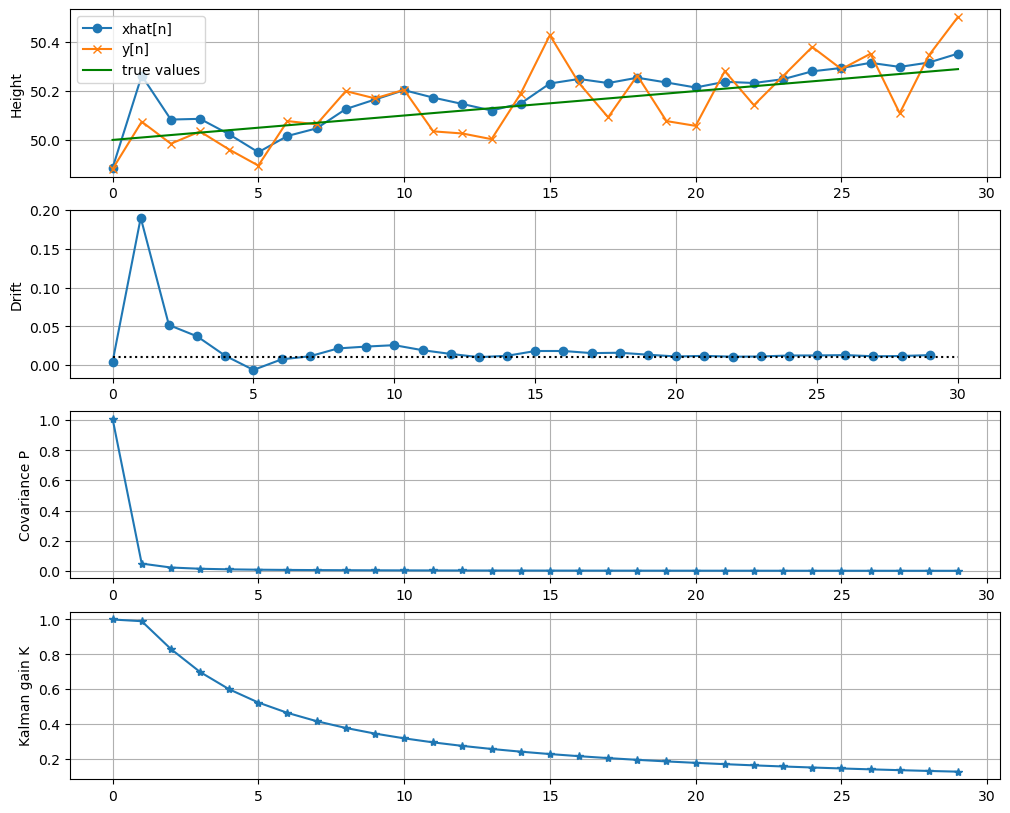

In [ ]:
# Measurement vector
y = np.array([49.8807, 50.0747, 49.9846, 50.0346, 49.9607, 49.8949, 50.0772,
              50.0638, 50.1999, 50.1702, 50.2053, 50.0351, 50.0264, 50.0031,
              50.1898, 50.4289, 50.2328, 50.0927, 50.2637, 50.0772, 50.0576,
              50.2817, 50.1422, 50.2616, 50.3807, 50.2901, 50.3530, 50.1094,
              50.3462, 50.5039])
sigma = 0.1

# true values
N = 30
x = np.arange(N)
T = 50 + 0.3*x/N

# Kalman Filter
A = np.array([[1, 1],
              [0, 1]], dtype=float)
B = np.array([[0]], dtype=float)
C = np.array([[1, 0]], dtype=float)
x0 = np.array([[10], [0]], dtype=float)
P0 = A @ np.diag([10000, 1]) @ A.T
R = sigma**2
Q = 0.000

kf = KalmanFilter(A, B, C, Q, R, x0, P0)

xhat = np.zeros_like(y)
dhat = np.zeros_like(y)
P = np.zeros_like(y)
K = np.zeros_like(y)

for n in range(len(y)):
    kf.kalman_update(y[n], 0)
    xhat[n] = kf.x[0,0]
    dhat[n] = kf.x[1,0]
    P[n] = kf.P[0,0]
    K[n] = kf.K[0,0]

print(xhat[29])
print(np.sqrt(P[29]))
print(np.sqrt(np.mean((T-xhat)**2)))

# Visualization
plt.figure(1, figsize=(12,10))
plt.subplot(411)
plt.plot(xhat, '-o')
plt.plot(y, '-x')
plt.plot(T, '-g')
plt.ylabel('Height')
plt.grid(True)
plt.legend(["xhat[n]", 'y[n]', 'true values'])

plt.subplot(412)
plt.plot(dhat, '-o')
plt.ylabel('Drift')
plt.hlines(0.3/N, 0, len(xhat), 'k', ':')
plt.grid(True)

plt.subplot(413)
plt.plot(P, '-*')
plt.ylabel('Covariance P')
plt.grid(True)

plt.subplot(414)
plt.plot(K, '-*')
plt.ylabel('Kalman gain K')
plt.grid(True)
plt.show()

### Extended Kalman-Filter

In [ ]:
Ts = 5
known_landmark_pos = (0,0)
u = 0

In [ ]:
def f(x, u):
    """Nonlinear state transition function with control inputs"""
    x,y,phi = x[0], x[1], x[2]
    v,w = u[0], u[1]
    return np.array([x + v*np.cos(phi)*Ts,
                     y + v*np.sin(phi)*Ts,
                     phi + w*Ts]) 


def F(x, u):
    """State transition Jacobi matrix"""
    x,y,phi = x[0], x[1], x[2]
    v,w = u[0], u[1]

    return np.array([[1, 0, -v*np.sin(phi)*Ts],
                     [0, 1, v*np.cos(phi)*Ts],
                     [0, 0, 1]])


def h(x):
    """Nonlinear observation model"""
    x,y,phi = x[0], x[1], x[2]
    xl, yl = known_landmark_pos

    x_delta = xl - x
    y_delta = yl - y

    r = np.sqrt(x_delta**2 + y_delta**2)
    b = np.arctan2(y_delta, x_delta) - phi

    return np.array([r, b])

def H(x):
    x,y,phi = x[0], x[1], x[2]
    xl, yl = known_landmark_pos

    x_delta = xl - x
    y_delta = yl - y

    r = np.sqrt(x_delta**2 + y_delta**2) + 1e-3

    return np.array([
        [-x_delta/r,     -y_delta/r,   0],
        [y_delta/r**2, -x_delta/r**2, -1]
    ])

In [ ]:
stateDim = 3
xhat = np.zeros((stateDim, N-1))
yHat = np.zeros((2, N-1))
P = np.zeros((stateDim, stateDim, N-1))

# Initial values and noise parameters
xhat[:, 0] = np.array([0.1, 0.1, 0.005])
P[:, :, 0] = np.diag([2, 2, 0.5])
Q = np.diag([5e-2, 5e-2, 2e-3])
R = np.diag([0.2, 0.025])

kf = KalmanFilter(f, F, h, H, Q, R, xhat[:, 0], P[:, :, 0])

In [ ]:
for n in range(1, N-1):
    kf.kalman_update(y[:,n], u[:,n])
    xhat[:,n] = kf.x
    P[:,:,n] = kf.P
    yHat[:,n] = h(kf.x)

### Median Filter

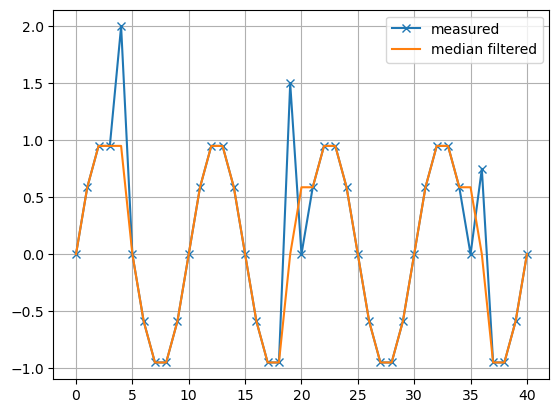

In [ ]:
y = np.array([0, 0.5878, 0.9511, 0.9511, 2.0000, 0.0000, -0.5878, -0.9511, -0.9511, -0.5878, -0.0000,
0.5878, 0.9511, 0.9511, 0.5878, 0.0000, -0.5878, -0.9511, -0.9511, 1.5000, -0.0000, 0.5878,
0.9511, 0.9511, 0.5878, 0.0000, -0.5878, -0.9511, -0.9511, -0.5878, -0.0000, 0.5878, 0.9511,
0.9511, 0.5878, 0.0000, 0.7500, -0.9511, -0.9511, -0.5878, -0.0000])

y_filt = sig.medfilt(y, 3)

plt.figure()
plt.plot(y, '-x')
plt.plot(y_filt)
plt.legend(['measured', 'median filtered'])
plt.grid(True)

### Backpropagation

In [3]:
def relu(X):
    return np.where(X>0, X, 0)

def diffRelu(X):
    return (X >= 0)*1

def sigmoid(X):
    return 1/(1 + np.exp(-X))

def diffSigmoid(X):
    return sigmoid(X) * (1 - sigmoid(X))

def MSELoss(y, d):
    return 0.5*(d - y)**2

def diffMSELoss(y, d):
    return y - d

def LogisticLoss(y, d):
    return -(d * np.log(y) + (1-d)*np.log(1-y))

def diffLogisticLoss(y, d):
    return - d/y + (1-d)/(1-y)


In [30]:
alpha = 0.9 # learning rate

# intial weights
W1 = np.array([[0,0],
               [0,0]], dtype=float)

W2 = np.array([[1,1]], dtype=float)

# input
X = np.array([[1],
              [1]], dtype=float)

# desired output
d = np.array([[1.5]], dtype=float)

# forward pass
print('Forward:')
## Layer 1
v1 = W1@X
y1 = sigmoid(v1)
print(f'v1 = {v1}')
print(f'y1 = {y1}')

## Layer 2 (Output Layer)
v2 = W2@y1
y2 = sigmoid(v2)  
print(f'v2 = {v2}')
print(f'y2 = {y2}')
print()

# lossfunction
loss = MSELoss(y2, d)
e = diffMSELoss(y2, d)
print('Loss:')
print(f'loss = {loss}') 
print(f'diffLoss = {e}')
print()

# backpropagation
dy2 = e
dv2 = dy2 * diffSigmoid(v2)
dW2 = np.outer(dv2, y1) 
print('Backprop Layer 2:')
print(f'dy2 = {dy2}')
print(f'dv2 = {dv2}')
print(f'dW2 = {dW2}')
print()

dy1 = W2.T @ dv2
dv1 = dy1 * diffSigmoid(v1)
dW1 = np.outer(dv1, X)
print('Backprop Layer 1:')
print(f'dy1 = {dy1}')
print(f'dv1 = {dv1}')
print(f'dW1 = {dW1}')
print()

W1 = W1 - alpha * dW1
W2 = W2 - alpha * dW2
print('Update:')
print(f'W2: {W2}')
print(f'W1: {W1}')


Forward:
v1 = [[0.]
 [0.]]
y1 = [[0.5]
 [0.5]]
v2 = [[1.]]
y2 = [[0.73105858]]

Loss:
loss = [[0.29563545]]
diffLoss = [[-0.76894142]]

Backprop Layer 2:
dy2 = [[-0.76894142]]
dv2 = [[-0.15118306]]
dW2 = [[-0.07559153 -0.07559153]]

Backprop Layer 1:
dy1 = [[-0.15118306]
 [-0.15118306]]
dv1 = [[-0.03779576]
 [-0.03779576]]
dW1 = [[-0.03779576 -0.03779576]
 [-0.03779576 -0.03779576]]

Update:
W2: [[1.06803238 1.06803238]]
W1: [[0.03401619 0.03401619]
 [0.03401619 0.03401619]]
